In [3]:
##### Audio Classification Using Machine Learning
#####dataset url https://urbansounddataset.weebly.com/urbansound8k.html

In [4]:
!pip install librosa

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [9]:
from sklearn.model_selection import RepeatedKFold

In [10]:
!pip install tensorflow

In [170]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier


2.7.0


In [173]:
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)


In [174]:
file_path = '/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/'


In [175]:
metadata = pd.read_csv('/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head(11)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

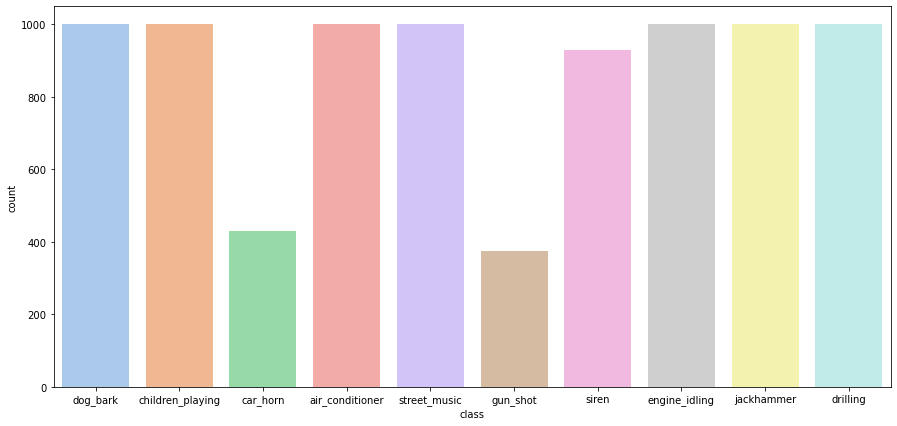

In [176]:
#graphical representation of the balance of the classes
plt.figure(figsize=(15,7))
sns.countplot(metadata['class'], palette = 'pastel')

In [177]:
metadata['class'].value_counts()

engine_idling       1000
dog_bark            1000
air_conditioner     1000
drilling            1000
street_music        1000
children_playing    1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fold', ylabel='count'>

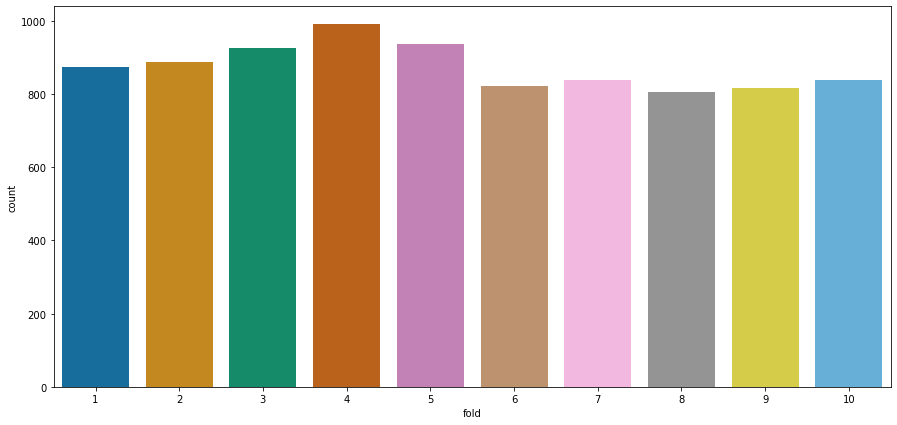

In [178]:
#graphical representation of the balance of the folds
plt.figure(figsize=(15,7))
sns.countplot(metadata['fold'], palette = 'colorblind')

In [179]:
metadata['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [180]:
# add duration feature and evaluate file durations

metadata['duration'] = metadata['end'] - metadata['start']
metadata['duration'].describe()

count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64

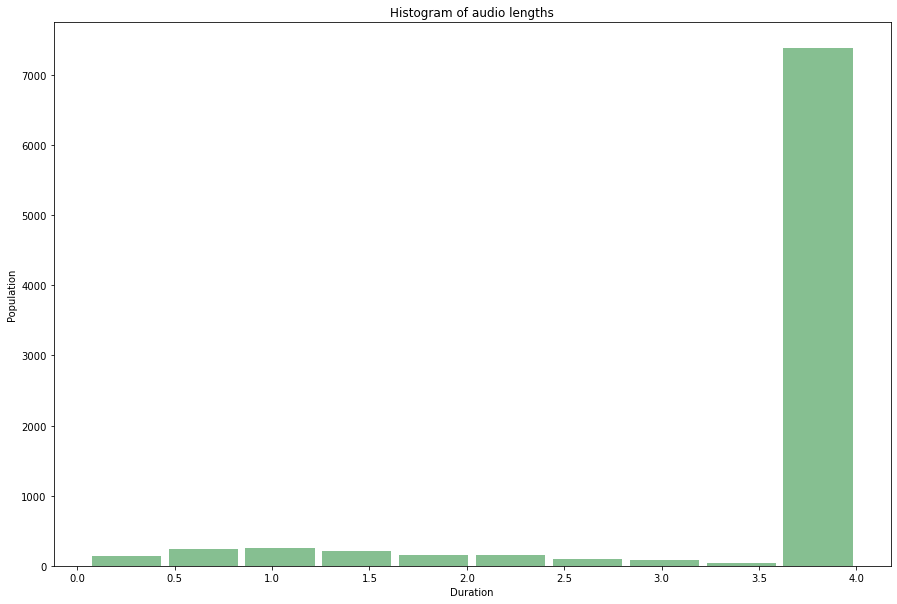

Greater than 3 seconds: 7468
Lower than 3 seconds: 1264
Lower than 1.5 seconds: 785


In [181]:
plt.hist(metadata['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = metadata['duration'][metadata['duration'] > 3].count()
lt_3sec = metadata['duration'][metadata['duration'] < 3].count()
lt_15sec = metadata['duration'][metadata['duration'] < 1.5].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 seconds: {}".format(lt_3sec))
print("Lower than 1.5 seconds: {}".format(lt_15sec))

In [182]:
###read a sample with librosa
ipd.Audio('/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav')

In [183]:
#load the wav
data, sample_rate=librosa.load('/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
print ('shape is {}, sample_rate is{}'.format(data.shape, sample_rate))

shape is (7002,), sample_rate is22050


In [184]:
data, sample_rate

(array([-0.00346022, -0.00502555, -0.00465325, ..., -0.00248061,
        -0.00155105, -0.0003528 ], dtype=float32),
 22050)

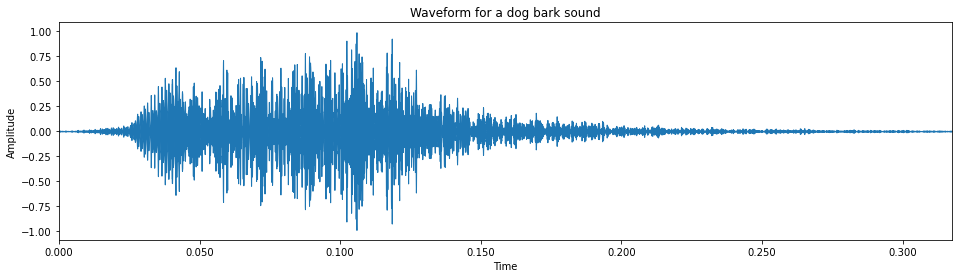

In [185]:
# Seeing how the sound looks like on a wave plot
fig, ax = plt.subplots(figsize = (16, 4))
librosa.display.waveplot(data, sr = sample_rate)
plt.ylabel('Amplitude')
plt.title('Waveform for a dog bark sound')
plt.show()

In [186]:
data, sample_rate=librosa.load('/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)

In [187]:
####EXTRACT FEATURES:ere we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. 
#The MFCC summarises the frequency distribution across the window size, so it is possible 
#to analyse both the frequency and time characteristics of the sound. 
#These audio representations will allow us to identify features for classification.
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T,axis=0)
print(mfccs.max(),mfccs.min())
print(mfccs.shape)

63.42263 -209.93578
(40,)


In [188]:
mfccs

array([-209.93578   ,   63.42263   , -123.69025   ,  -60.019203  ,
        -14.457383  ,  -29.090641  ,   -4.2511783 ,   12.419748  ,
         12.739302  ,    9.053966  ,   -6.8080783 ,   -2.1365588 ,
        -13.349953  ,    6.6780252 ,   -3.144794  ,   -3.695392  ,
        -15.768193  ,   -0.38718554,   -3.2507935 ,    6.490812  ,
        -11.352611  ,   -7.6883025 ,    5.4163556 ,   -2.7029934 ,
         -6.27998   ,    0.45257625,   -3.8793392 ,    5.3696904 ,
         -6.6641655 ,   -4.454918  ,    0.39725345,    8.100588  ,
         -1.0730537 ,    2.7207093 ,   -6.7139773 ,   -1.8797903 ,
          2.0122087 ,   -0.66254216,   -1.8982313 ,    1.3549525 ],
      dtype=float32)

In [189]:
##Extracting MFCC's for every audio file
def get_features(file):
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [190]:
####USE CROSS VALIDATION: I use cross validation considering all my dataset to see how models performed better
features = []

for index,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/'+str(row["slice_file_name"]))
    label_class = str(row["class"])
    
    data = get_features(file_name)
    features.append([data,label_class])

3555it [04:30,  8.21it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [10:37, 20.28it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [11:06, 13.10it/s]


In [191]:
#Converting extracted featured to Pandas dataframe
features_df=pd.DataFrame(features, columns=['Features','Class'])
features_df.head(10)

,Features,Class
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01073, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing
5,"[-447.70856, 118.409454, -35.24866, 56.73993, ...",children_playing
6,"[-477.1972, 120.63773, -29.692501, 57.05191, 1...",children_playing
7,"[-464.84656, 117.71454, -30.163273, 50.72254, ...",children_playing
8,"[-472.1215, 126.76601, -38.36653, 58.748646, -...",children_playing
9,"[-196.18527, 114.94506, -14.661185, 1.2298628,...",car_horn


In [192]:
X=np.array(features_df['Features'].tolist())
y=np.array(features_df['Class'].tolist())

In [193]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [194]:
###Model with 2 hidden layers(512 and 128n)
def model1_cv():
    n_labels = y.shape[1]
    
    model1_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model1_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model1_cv

In [195]:
estimator = KerasClassifier(build_fn=model1_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10,random_state=1, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-195-1add0c73b5a4>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model1_cv, epochs=100, verbose=0)


Accuracy: 91.79% (1.62%)


In [197]:
#####Model with 2 hidden layer and Dropout(0.3)
def model2_cv():
    n_labels = y.shape[1]
    
    model2_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model2_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model2_cv
    

In [198]:
estimator = KerasClassifier(build_fn=model2_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-198-89be3e7fa37f>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model2_cv, epochs=100, verbose=0)


Accuracy: 90.66% (1.02%)


In [199]:
####Model with 2 hidden layer, Droupout(0.3) and Batch Normalization
def model3_cv():
    n_labels = y.shape[1]
    
    model3_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model3_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model3_cv

In [200]:
estimator = KerasClassifier(build_fn=model3_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10,random_state=1, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-200-ce5b6de2b690>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model3_cv, epochs=100, verbose=0)


Accuracy: 90.86% (1.04%)


In [265]:
df = pd.DataFrame({'Accuracy':[str(91.79)+'%', str(90.66)+'%', str(90.86)+'%'],
       'St.Err.': [str(1.62)+'%', str(1.02)+'%', str(1.03)+'%']},
                 index=['Model1', 'Model2', 'Model3']) 
df

,Accuracy,St.Err.
Model1,91.79%,1.62%
Model2,90.66%,1.02%
Model3,90.86%,1.03%


In [202]:
trainingset = []
for index,row in tqdm(metadata.iterrows()):
    if (str(row["fold"]) == "1"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold1/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        trainingset.append([data,label_class])
    elif(str(row["fold"]) == "2"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold2/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        trainingset.append([data,label_class])
    elif (str(row["fold"]) == "3"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold3/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        trainingset.append([data,label_class])
    elif (str(row["fold"]) == "4"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold4/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        trainingset.append([data,label_class])
    elif (str(row["fold"]) == "6"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold6/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        trainingset.append([data,label_class])
    else:
        continue
        
Trainingset_mfcc=pd.DataFrame(trainingset, columns=['Features', 'Class'])
Trainingset_mfcc.shape     

3554it [02:46, 17.49it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8307it [05:35, 39.28it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8327it [05:36, 51.60it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [05:50, 24.89it/s]


(4499, 2)

In [203]:
Trainingset_mfcc.head()

,Features,Class
0,"[-275.89142, 101.7432, -91.016815, -4.603029, ...",dog_bark
1,"[-294.21707, 104.33867, -98.29193, -8.635915, ...",dog_bark
2,"[-301.5207, 105.01332, -92.563484, -10.303136,...",dog_bark
3,"[-299.53833, 105.0457, -95.95926, -11.808134, ...",dog_bark
4,"[-193.32758, 36.054405, -63.924595, 6.513842, ...",dog_bark


In [204]:
test_fold5 = []
test_fold7 = []
test_fold8 = []
test_fold9 = []
test_fold10 = []


for index,row in tqdm(metadata.iterrows()):
    if (str(row["fold"]) == "5"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        test_fold5.append([data,label_class])
    elif (str(row["fold"]) == "7"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold7/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        test_fold7.append([data,label_class])
    elif (str(row["fold"]) == "8"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold8/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        test_fold8.append([data,label_class])
    elif (str(row["fold"]) == "9"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold9/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        test_fold9.append([data,label_class])
    elif (str(row["fold"]) == "10"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold10/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_features(file_name)
        test_fold10.append([data,label_class])
    else:
        continue

fold5 = pd.DataFrame(test_fold5,columns=['Features','Class'])
fold7 = pd.DataFrame(test_fold7,columns=['Features','Class'])
fold8 = pd.DataFrame(test_fold8,columns=['Features','Class'])
fold9 = pd.DataFrame(test_fold9,columns=['Features','Class'])
fold10 = pd.DataFrame(test_fold10,columns=['Features','Class'])

fold5.shape, fold7.shape, fold8.shape, fold9.shape, fold10.shape

8732it [04:53, 29.74it/s]


((936, 2), (838, 2), (806, 2), (816, 2), (837, 2))

In [205]:
fold5.head()

,Features,Class
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01073, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing


In [206]:
### Split the dataset into features and labels
X_train = np.array(Trainingset_mfcc['Features'].tolist())
Y_train = np.array(Trainingset_mfcc['Class'].tolist())

X_fold5 = np.array(fold5['Features'].tolist())
Y_fold5 = np.array(fold5['Class'].tolist())

X_fold7 = np.array(fold7['Features'].tolist())
Y_fold7 = np.array(fold7['Class'].tolist())

X_fold8 = np.array(fold8['Features'].tolist())
Y_fold8 = np.array(fold8['Class'].tolist())

X_fold9 = np.array(fold9['Features'].tolist())
Y_fold9 = np.array(fold9['Class'].tolist())

X_fold10 = np.array(fold10['Features'].tolist())
Y_fold10 = np.array(fold10['Class'].tolist())

In [207]:
### Label Encoding
labelencoder = LabelEncoder()
Y_train = to_categorical(labelencoder.fit_transform(Y_train))

Y_fold5 = to_categorical(labelencoder.fit_transform(Y_fold5))
Y_fold7 = to_categorical(labelencoder.fit_transform(Y_fold7))
Y_fold8 = to_categorical(labelencoder.fit_transform(Y_fold8))
Y_fold9 = to_categorical(labelencoder.fit_transform(Y_fold9))
Y_fold10 = to_categorical(labelencoder.fit_transform(Y_fold10))

In [208]:
print('Train shape:')
print('X: ',X_train.shape)
print('y: ',Y_train.shape)

print('Test shape')
print('X: ',X_fold5.shape)
print('y: ',Y_fold5.shape)

Train shape:
X:  (4499, 40)
y:  (4499, 10)
Test shape
X:  (936, 40)
y:  (936, 10)


In [209]:
X_train, X_train.shape

(array([[-2.7589142e+02,  1.0174320e+02, -9.1016815e+01, ...,
          9.7096197e-02,  2.6730344e+00,  8.5336030e-01],
        [-2.9421707e+02,  1.0433867e+02, -9.8291931e+01, ...,
         -6.8780518e-01,  1.6340903e+00,  1.6499337e+00],
        [-3.0152069e+02,  1.0501332e+02, -9.2563484e+01, ...,
         -3.1876016e-01,  1.0875399e+00,  4.7585857e-01],
        ...,
        [-1.1965828e+02,  1.4271477e+02, -4.7209030e+01, ...,
         -1.3909954e+00,  2.1198912e+00,  5.7377915e+00],
        [-1.1181638e+02,  1.3991504e+02, -4.1092350e+01, ...,
         -2.3852682e+00,  3.8598619e+00,  8.1123943e+00],
        [-9.1143326e+01,  1.3814082e+02, -4.9765118e+01, ...,
         -1.9491849e+00,  1.5663247e+00,  6.2767806e+00]], dtype=float32),
 (4499, 40))

In [210]:
Y_fold5, Y_fold5.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (936, 10))

In this step, we will create a models using TensorFlow. Our layers will be stacked in sequence. The last layer will have a softmax activation layer because it is a multi-class classification problem. We can summarize the construction of deep learning models in Keras using the Sequential model as follows: 1.Define your model: create a Sequential model and add layers. 2.Compile your model: specify loss function and optimizers and call the .compile() function. 3.Fit your model: train the model on data by calling the .fit() function. 4.Make predictions: use the model to generate predictions on new data by calling functions such as .evaluate() or .predict().

Dropout is regularization technique to avoid overfitting (increase the validation accuracy) thus increasing the generalizing power. -Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network. -Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.

In [283]:
###MODEL3_NN with Dropout and batch normalizzation
num_labels = Y_train.shape[1]

model3_NN = tf.keras.Sequential([
    tf.keras.layers.Dense(512,input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model3_NN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [284]:
model3_NN.summary()

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_564 (Dense)           (None, 512)               20992     
                                                                 
 dropout_303 (Dropout)       (None, 512)               0         
                                                                 
 batch_normalization_138 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_565 (Dense)           (None, 128)               65664     
                                                                 
 dropout_304 (Dropout)       (None, 128)               0         
                                                                 
 batch_normalization_139 (Ba  (None, 128)              512       
 tchNormalization)                                  

In [285]:
history = model3_NN.fit(X_train, Y_train, epochs=100, validation_data=(X_fold5, Y_fold5), verbose=1)

Epoch 1/100
141/141 [==============================] - 5s 8ms/step - loss: 2.3381 - accuracy: 0.2180 - val_loss: 2.3299 - val_accuracy: 0.1132
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 1.9677 - accuracy: 0.2954 - val_loss: 2.6038 - val_accuracy: 0.1560
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 1.8530 - accuracy: 0.3343 - val_loss: 2.3502 - val_accuracy: 0.2179
Epoch 4/100
141/141 [==============================] - 1s 5ms/step - loss: 1.7522 - accuracy: 0.3723 - val_loss: 1.9112 - val_accuracy: 0.3056
Epoch 5/100
141/141 [==============================] - 1s 5ms/step - loss: 1.6786 - accuracy: 0.4008 - val_loss: 1.9871 - val_accuracy: 0.3184
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 1.6538 - accuracy: 0.4059 - val_loss: 1.6592 - val_accuracy: 0.4060
Epoch 7/100
141/141 [==============================] - 1s 5ms/step - loss: 1.6123 - accuracy: 0.4268 - val_loss: 1.8018 - val_accuracy: 0.3889

Epoch 58/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1807 - accuracy: 0.5779 - val_loss: 1.7791 - val_accuracy: 0.4509
Epoch 59/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1778 - accuracy: 0.5850 - val_loss: 1.7706 - val_accuracy: 0.4647
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1770 - accuracy: 0.5928 - val_loss: 1.7874 - val_accuracy: 0.4733
Epoch 61/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1946 - accuracy: 0.5850 - val_loss: 1.7219 - val_accuracy: 0.4882
Epoch 62/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1730 - accuracy: 0.5866 - val_loss: 1.8090 - val_accuracy: 0.4915
Epoch 63/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1689 - accuracy: 0.5946 - val_loss: 1.6872 - val_accuracy: 0.5085
Epoch 64/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1645 - accuracy: 0.5904 - val_loss: 1.7952 - val_accuracy:

In [286]:
accuracy = []

test_accuracy = model3_NN.evaluate(X_fold5,Y_fold5,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model3_NN.evaluate(X_fold7,Y_fold7,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model3_NN.evaluate(X_fold8,Y_fold8,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model3_NN.evaluate(X_fold9,Y_fold9,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model3_NN.evaluate(X_fold10,Y_fold10,verbose=0)
value = test_accuracy[1]
accuracy.append(value)


avg_accuracy = np.mean(accuracy)
avg_accuracy

0.41168596744537356

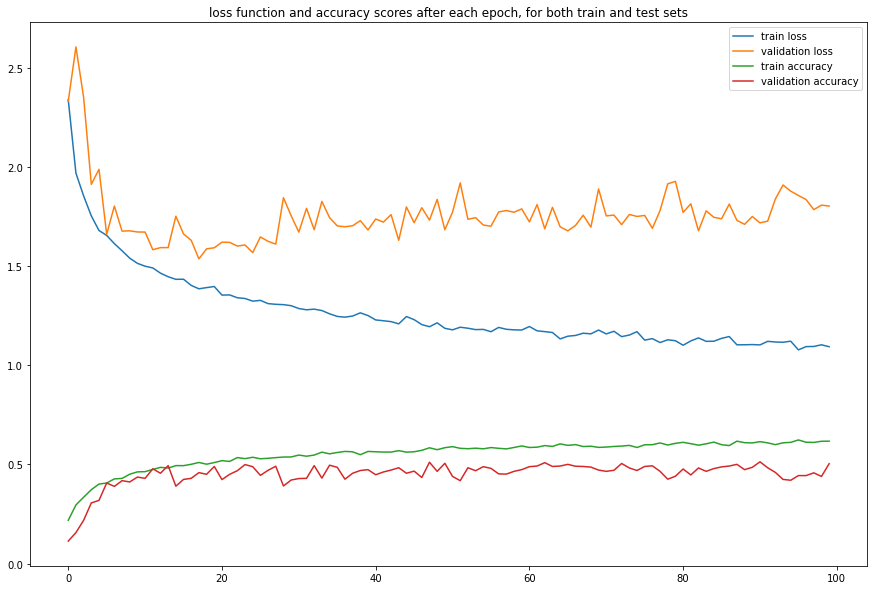

In [287]:
# Plot loss per iteration
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.title("loss function and accuracy scores after each epoch, for both train and test sets")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.savefig("/Users/DELL/OneDrive/Desktop/DSE/Machine Learning/accloss.jpg")

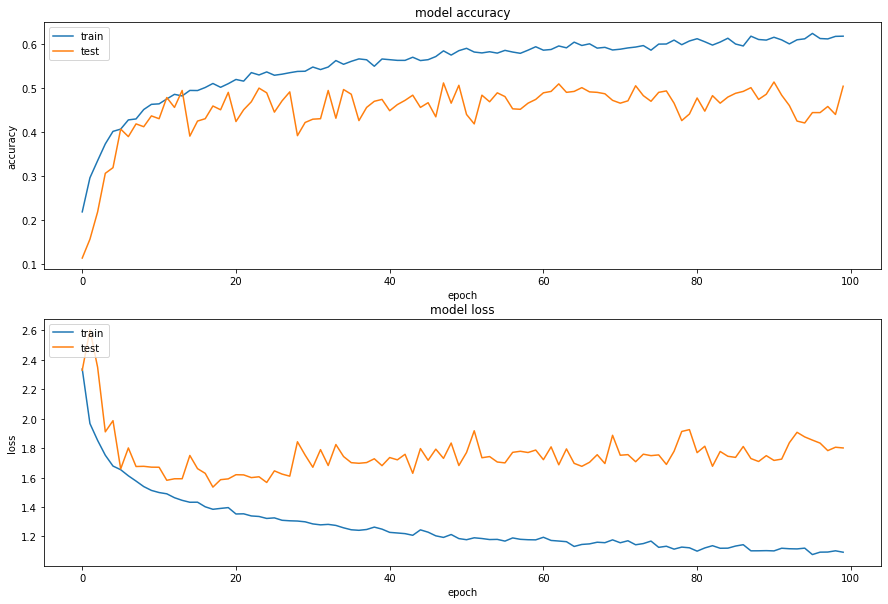

In [288]:
plt.figure(1) 
   
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [289]:
num_labels = Y_train.shape[1]
    
model2_NN = tf.keras.Sequential([
tf.keras.layers.Dense(128,input_shape=(40,)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(num_labels, activation='softmax')])
    
model2_NN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
     

In [290]:
model2_NN.summary()

Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_568 (Dense)           (None, 128)               5248      
                                                                 
 dropout_306 (Dropout)       (None, 128)               0         
                                                                 
 dense_569 (Dense)           (None, 512)               66048     
                                                                 
 dropout_307 (Dropout)       (None, 512)               0         
                                                                 
 dense_570 (Dense)           (None, 128)               65664     
                                                                 
 dropout_308 (Dropout)       (None, 128)               0         
                                                                 
 dense_571 (Dense)           (None, 10)             

In [291]:
history = model2_NN.fit(X_train, Y_train, epochs=10, validation_data=(X_fold5, Y_fold5), verbose=1)

Epoch 1/10
141/141 [==============================] - 1s 5ms/step - loss: 2.1873 - accuracy: 0.1774 - val_loss: 2.0498 - val_accuracy: 0.2660
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 1.9002 - accuracy: 0.3007 - val_loss: 1.8514 - val_accuracy: 0.3472
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 1.6954 - accuracy: 0.3832 - val_loss: 1.6980 - val_accuracy: 0.4156
Epoch 4/10
141/141 [==============================] - 1s 6ms/step - loss: 1.5685 - accuracy: 0.4383 - val_loss: 1.7758 - val_accuracy: 0.3718
Epoch 5/10
141/141 [==============================] - 1s 6ms/step - loss: 1.5059 - accuracy: 0.4570 - val_loss: 1.6178 - val_accuracy: 0.4092
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 1.4291 - accuracy: 0.4968 - val_loss: 1.6051 - val_accuracy: 0.4498
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 1.3899 - accuracy: 0.5010 - val_loss: 1.6319 - val_accuracy: 0.4177
Epoch 

In [292]:
accuracy = []

test_accuracy = model2_NN.evaluate(X_fold5,Y_fold5,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2_NN.evaluate(X_fold7,Y_fold7,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2_NN.evaluate(X_fold8,Y_fold8,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2_NN.evaluate(X_fold9,Y_fold9,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2_NN.evaluate(X_fold10,Y_fold10,verbose=0)
value = test_accuracy[1]
accuracy.append(value)


avg_accuracy = np.mean(accuracy)
avg_accuracy

0.40235552191734314

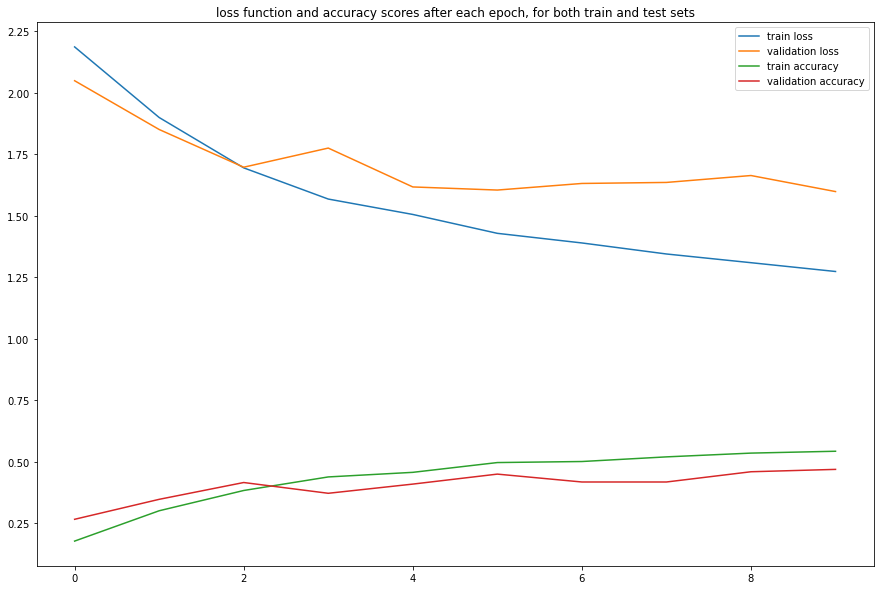

In [293]:
# Plot loss per iteration
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.title("loss function and accuracy scores after each epoch, for both train and test sets")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.savefig("/Users/DELL/OneDrive/Desktop/DSE/Machine Learning/accloss2.jpg")

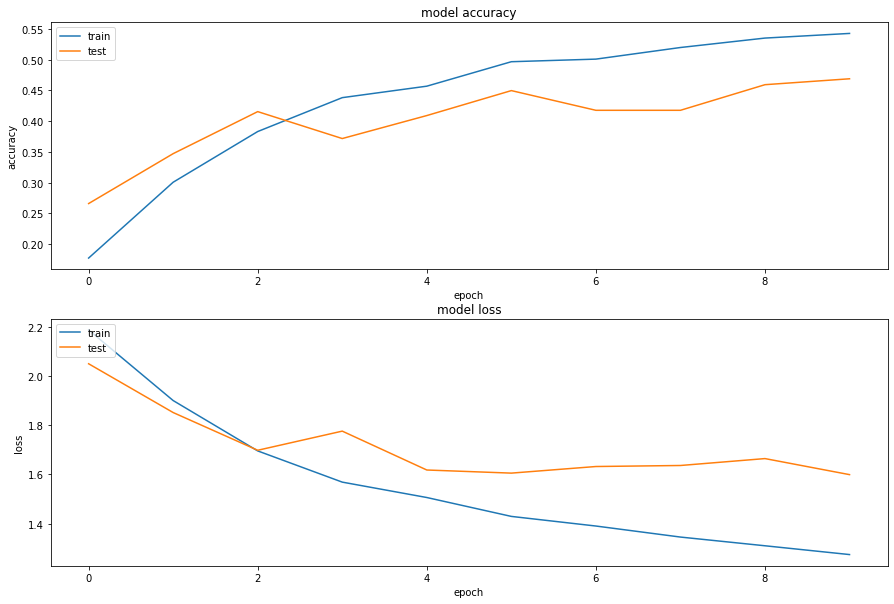

In [294]:
plt.figure(1) 
   
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [318]:
num_labels = Y_train.shape[1]
    
model1_NN = tf.keras.Sequential([
tf.keras.layers.Dense(128,input_shape=(40,)),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(num_labels, activation='softmax')])
    
model1_NN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [319]:
model1_NN.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_576 (Dense)           (None, 128)               5248      
                                                                 
 dense_577 (Dense)           (None, 512)               66048     
                                                                 
 dense_578 (Dense)           (None, 128)               65664     
                                                                 
 dense_579 (Dense)           (None, 10)                1290      
                                                                 
Total params: 138,250
Trainable params: 138,250
Non-trainable params: 0
_________________________________________________________________


In [322]:
history1 = model1_NN.fit(X_train, Y_train, epochs=100, validation_data=(X_fold5, Y_fold5), verbose=1)

Epoch 1/100
141/141 [==============================] - 0s 4ms/step - loss: 0.8571 - accuracy: 0.7075 - val_loss: 1.8339 - val_accuracy: 0.4658
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8301 - accuracy: 0.7106 - val_loss: 2.0045 - val_accuracy: 0.4509
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7789 - accuracy: 0.7373 - val_loss: 1.9759 - val_accuracy: 0.4850
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7691 - accuracy: 0.7377 - val_loss: 2.1110 - val_accuracy: 0.4498
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.7475 - val_loss: 1.9964 - val_accuracy: 0.4551
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7020 - accuracy: 0.7586 - val_loss: 2.0869 - val_accuracy: 0.4530
Epoch 7/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6731 - accuracy: 0.7619 - val_loss: 2.1891 - val_accuracy: 0.4626

Epoch 58/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1588 - accuracy: 0.9458 - val_loss: 4.7195 - val_accuracy: 0.4338
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1720 - accuracy: 0.9435 - val_loss: 4.7362 - val_accuracy: 0.4295
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9595 - val_loss: 4.5352 - val_accuracy: 0.4573
Epoch 61/100
141/141 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9467 - val_loss: 5.3191 - val_accuracy: 0.4092
Epoch 62/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1202 - accuracy: 0.9633 - val_loss: 5.4072 - val_accuracy: 0.4038
Epoch 63/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1295 - accuracy: 0.9575 - val_loss: 4.9270 - val_accuracy: 0.4316
Epoch 64/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1237 - accuracy: 0.9584 - val_loss: 5.2818 - val_accuracy:

In [323]:
accuracy = []

test_accuracy = model1_NN.evaluate(X_fold5,Y_fold5,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1_NN.evaluate(X_fold7,Y_fold7,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1_NN.evaluate(X_fold8,Y_fold8,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1_NN.evaluate(X_fold9,Y_fold9,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1_NN.evaluate(X_fold10,Y_fold10,verbose=0)
value = test_accuracy[1]
accuracy.append(value)


avg_accuracy = np.mean(accuracy)
avg_accuracy

0.37483031749725343

In [331]:
df = pd.DataFrame({'MFCC Accuracy':[str(37.5)+'%',str(41.2)+'%', str(40.2)+'%'],'Chroma Accuracy':[str(38.4)+'%',str(38.7)+'%', str(0)+'%']},
                 index=['Model1', 'Model2', 'Model3']) 
df

,MFCC Accuracy,Chroma Accuracy
Model1,37.5%,38.4%
Model2,41.2%,38.7%
Model3,40.2%,0%


NOW WE EXTRACT THE CHROMAGRAM FEATURE Chroma Features In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

In [224]:
data, sample_rate=librosa.load('/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
chroma=librosa.feature.chroma_stft(y=data, sr=sample_rate,n_chroma=40)
chroma.shape
chroma

array([[0.06784214, 0.03653395, 0.14451778, 0.532895  , 0.41430506,
        0.21749756, 0.3419956 , 0.17985173, 0.19505554, 0.33065987,
        0.16094336, 0.23370582, 0.29423442, 0.13490824],
       [0.08701078, 0.01440925, 0.04423781, 0.36561692, 0.23972408,
        0.19968526, 0.21286732, 0.2064054 , 0.13919358, 0.12223718,
        0.11968958, 0.09727897, 0.09711967, 0.0729048 ],
       [0.04019055, 0.00759871, 0.04658814, 0.16309343, 0.10881723,
        0.23498122, 0.438387  , 0.491152  , 0.15549603, 0.19801971,
        0.20880634, 0.21809526, 0.18396752, 0.13267365],
       [0.01526497, 0.00727723, 0.04644716, 0.15881905, 0.23083569,
        0.53792346, 1.        , 0.77325374, 0.60489035, 0.5395942 ,
        0.24028516, 0.19956356, 0.38721555, 0.3988565 ],
       [0.02054251, 0.00489875, 0.0368928 , 0.14621043, 0.18848753,
        0.42522246, 0.89016104, 1.        , 1.        , 0.29715034,
        0.2326394 , 0.17758185, 0.17302352, 0.6122523 ],
       [0.01395121, 0.00369636, 0.0

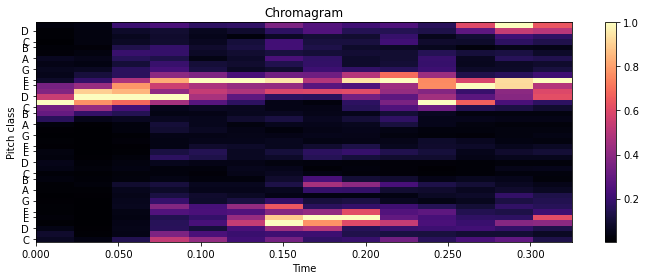

In [225]:
#Chromagram of dog bark
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [226]:
#####Defining a function that extracts the Chromagram feature from a single audio file
def get_chroma(file):
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    chroma_features = librosa.feature.chroma_stft(y=data, sr=sample_rate, n_chroma=40)
    chroma_scaled_features = np.mean(chroma_features.T, axis=0)
    
    return chroma_scaled_features

In [227]:
####10-cv with chromagram feature
chfeatures = []

for index,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/'+str(row["slice_file_name"]))
    label_class = str(row["class"])
    data = get_chroma(file_name)
    chfeatures.append([data,label_class])

67it [00:04, 13.62it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
3555it [04:28, 13.49it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [10:24, 19.34it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [10:53, 13.36it/s]


In [228]:
chfeatures_df = pd.DataFrame(chfeatures,columns=['Features','Class'])
chfeatures_df.head()

,Features,Class
0,"[0.23463225, 0.14415364, 0.1876867, 0.36711416...",dog_bark
1,"[0.311111, 0.30781618, 0.33181983, 0.33207315,...",children_playing
2,"[0.3856114, 0.42340618, 0.44800016, 0.42128587...",children_playing
3,"[0.3715312, 0.3859846, 0.3820113, 0.39440072, ...",children_playing
4,"[0.5069898, 0.5173537, 0.5118571, 0.5463822, 0...",children_playing


In [229]:
X = np.array(chfeatures_df['Features'].tolist())
Y = np.array(chfeatures_df['Class'].tolist())

In [230]:
labelencoder = LabelEncoder()
Y = to_categorical(labelencoder.fit_transform(Y))

In [231]:
####MODEL 1
def model1c_cv():
    n_labels = Y.shape[1]
    
    model1c_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model1c_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model1c_cv

In [232]:
estimator = KerasClassifier(build_fn=model1c_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-232-f1343246526d>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model1c_cv, epochs=100, verbose=0)


Accuracy: 70.56% (1.50%)


In [233]:
#####Model with 2 hidden layer and Dropout(0.3)
def model2c_cv():
    n_labels = Y.shape[1]
    
    model2c_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model2c_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model2c_cv

In [234]:
estimator = KerasClassifier(build_fn=model2c_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-234-17a6df4ac33f>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model2c_cv, epochs=100, verbose=0)


Accuracy: 70.28% (1.47%)


In [235]:
###MODEL 3 WITH DROPOUT AND BATCHNORMALIZATION
def model3c_cv():
    n_labels = Y.shape[1]
    
    model3c_cv = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(40,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_labels, activation='softmax')])
    
    model3c_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model3c_cv

In [236]:
estimator = KerasClassifier(build_fn=model3c_cv, epochs=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-236-6300ffc60815>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=model3c_cv, epochs=100, verbose=0)


Accuracy: 66.86% (1.77%)


In [266]:
df1 = pd.DataFrame({'Accuracy':[str(70.56)+'%', str(70.28)+'%', str(66.88)+'%'],
       'St.Err.': [str(1.50)+'%', str(1.47)+'%', str(1.77)+'%']},
                 index=['Model1', 'Model2', 'Model3']) 
df1

,Accuracy,St.Err.
Model1,70.56%,1.5%
Model2,70.28%,1.47%
Model3,66.88%,1.77%


In [238]:
chroma_train = []
for index,row in tqdm(metadata.iterrows()):
    if (str(row["fold"]) == "1"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold1/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        chroma_train.append([data,label_class])
    elif(str(row["fold"]) == "2"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold2/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        chroma_train.append([data,label_class])
    elif (str(row["fold"]) == "3"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold3/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        chroma_train.append([data,label_class])
    elif (str(row["fold"]) == "4"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold4/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        chroma_train.append([data,label_class])
    elif (str(row["fold"]) == "6"):
        file_name ="/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold6/" +str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        chroma_train.append([data,label_class])
    else:
        continue
        
chroma_train=pd.DataFrame(chroma_train, columns=['Features', 'Class'])
chroma_train.shape     

118it [00:01, 48.44it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
3554it [02:18, 16.90it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8323it [05:25, 37.77it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [05:43, 25.39it/s]


(4499, 2)

In [239]:
chroma_train.head()

,Features,Class
0,"[0.2710792, 0.27672955, 0.26019442, 0.28824687...",dog_bark
1,"[0.2520228, 0.25411195, 0.28011847, 0.28778392...",dog_bark
2,"[0.2233227, 0.2172269, 0.24068363, 0.26733828,...",dog_bark
3,"[0.19607443, 0.1807053, 0.20618178, 0.23650484...",dog_bark
4,"[0.3844667, 0.4533357, 0.47552526, 0.4666204, ...",dog_bark


In [240]:
test_fold5 = []
test_fold7 = []
test_fold8 = []
test_fold9 = []
test_fold10 = []


for index,row in tqdm(metadata.iterrows()):
    if (str(row["fold"]) == "5"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        test_fold5.append([data,label_class])
    elif (str(row["fold"]) == "7"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold7/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        test_fold7.append([data,label_class])
    elif (str(row["fold"]) == "8"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold8/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        test_fold8.append([data,label_class])
    elif (str(row["fold"]) == "9"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold9/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        test_fold9.append([data,label_class])
    elif (str(row["fold"]) == "10"):
        file_name = "/users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold10/" + str(row["slice_file_name"])
        label_class = str(row["class"])
        data = get_chroma(file_name)
        test_fold10.append([data,label_class])
    else:
        continue

fold5 = pd.DataFrame(test_fold5,columns=['Features','Class'])
fold7 = pd.DataFrame(test_fold7,columns=['Features','Class'])
fold8 = pd.DataFrame(test_fold8,columns=['Features','Class'])
fold9 = pd.DataFrame(test_fold9,columns=['Features','Class'])
fold10 = pd.DataFrame(test_fold10,columns=['Features','Class'])

fold5.shape, fold7.shape, fold8.shape, fold9.shape, fold10.shape

63it [00:06, 10.50it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
8732it [05:31, 26.34it/s]


((936, 2), (838, 2), (806, 2), (816, 2), (837, 2))

In [241]:
fold8.head()

,Features,Class
0,"[0.189138, 0.1922851, 0.19128238, 0.21139479, ...",dog_bark
1,"[0.18439794, 0.1867124, 0.21436809, 0.28241467...",dog_bark
2,"[0.095137335, 0.15184322, 0.22396974, 0.282998...",dog_bark
3,"[0.24265836, 0.22355193, 0.22022238, 0.2230266...",engine_idling
4,"[0.28011605, 0.26917058, 0.24652153, 0.2425813...",engine_idling


In [242]:
### Split the dataset into features and labels
X_train = np.array(chroma_train['Features'].tolist())
Y_train = np.array(chroma_train['Class'].tolist())

X_fold5 = np.array(fold5['Features'].tolist())
Y_fold5 = np.array(fold5['Class'].tolist())

X_fold7 = np.array(fold7['Features'].tolist())
Y_fold7 = np.array(fold7['Class'].tolist())

X_fold8 = np.array(fold8['Features'].tolist())
Y_fold8 = np.array(fold8['Class'].tolist())

X_fold9 = np.array(fold9['Features'].tolist())
Y_fold9 = np.array(fold9['Class'].tolist())

X_fold10 = np.array(fold10['Features'].tolist())
Y_fold10 = np.array(fold10['Class'].tolist())

In [243]:
### Label Encoding
labelencoder = LabelEncoder()
Y_train = to_categorical(labelencoder.fit_transform(Y_train))
Y_fold5 = to_categorical(labelencoder.fit_transform(Y_fold5))
Y_fold7 = to_categorical(labelencoder.fit_transform(Y_fold7))
Y_fold8 = to_categorical(labelencoder.fit_transform(Y_fold8))
Y_fold9 = to_categorical(labelencoder.fit_transform(Y_fold9))
Y_fold10 = to_categorical(labelencoder.fit_transform(Y_fold10))

In [326]:
num_labels = Y_train.shape[1]
    
model1 = tf.keras.Sequential([
tf.keras.layers.Dense(128,input_shape=(40,)),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(num_labels, activation='softmax')])
    
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [328]:
model1.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_580 (Dense)           (None, 128)               5248      
                                                                 
 dense_581 (Dense)           (None, 512)               66048     
                                                                 
 dense_582 (Dense)           (None, 128)               65664     
                                                                 
 dense_583 (Dense)           (None, 10)                1290      
                                                                 
Total params: 138,250
Trainable params: 138,250
Non-trainable params: 0
_________________________________________________________________


In [329]:
history1c = model1.fit(X_train, Y_train, epochs=100, validation_data=(X_fold5, Y_fold5), verbose=1)

Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 2.0427 - accuracy: 0.2481 - val_loss: 1.8413 - val_accuracy: 0.3408
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 1.5736 - accuracy: 0.4417 - val_loss: 1.5952 - val_accuracy: 0.4423
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 1.3609 - accuracy: 0.5194 - val_loss: 1.6765 - val_accuracy: 0.4327
Epoch 4/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2397 - accuracy: 0.5621 - val_loss: 1.7356 - val_accuracy: 0.4391
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1581 - accuracy: 0.5928 - val_loss: 1.7000 - val_accuracy: 0.4701
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 1.0777 - accuracy: 0.6235 - val_loss: 1.6059 - val_accuracy: 0.5139
Epoch 7/100
141/141 [==============================] - 1s 4ms/step - loss: 1.0227 - accuracy: 0.6386 - val_loss: 1.8088 - val_accuracy: 0.4412

Epoch 58/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1546 - accuracy: 0.9500 - val_loss: 4.3413 - val_accuracy: 0.4092
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1811 - accuracy: 0.9347 - val_loss: 5.1688 - val_accuracy: 0.3729
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1700 - accuracy: 0.9480 - val_loss: 4.7950 - val_accuracy: 0.4519
Epoch 61/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2171 - accuracy: 0.9262 - val_loss: 4.6941 - val_accuracy: 0.4103
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1330 - accuracy: 0.9607 - val_loss: 4.8222 - val_accuracy: 0.4316
Epoch 63/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1513 - accuracy: 0.9509 - val_loss: 4.8500 - val_accuracy: 0.4274
Epoch 64/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1449 - accuracy: 0.9509 - val_loss: 4.9096 - val_accuracy:

In [330]:
accuracy = []

test_accuracy = model1.evaluate(X_fold5,Y_fold5,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1.evaluate(X_fold7,Y_fold7,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1.evaluate(X_fold8,Y_fold8,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1.evaluate(X_fold9,Y_fold9,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model1.evaluate(X_fold10,Y_fold10,verbose=0)
value = test_accuracy[1]
accuracy.append(value)


avg_accuracy = np.mean(accuracy)
avg_accuracy

0.383976149559021

In [297]:
####MODEL
n_labels = Y_train.shape[1]

model2 = models.Sequential()
model2.add(Dense(128, input_shape=(40,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(n_labels))
model2.add(Activation('softmax'))


model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [304]:
history2c = model2.fit(X_train, Y_train, epochs=100, validation_data=(X_fold5, Y_fold5), verbose=1)

Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.7693 - val_loss: 2.1286 - val_accuracy: 0.4637
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6506 - accuracy: 0.7639 - val_loss: 2.1762 - val_accuracy: 0.4904
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6371 - accuracy: 0.7695 - val_loss: 2.3622 - val_accuracy: 0.4380
Epoch 4/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6417 - accuracy: 0.7677 - val_loss: 2.2536 - val_accuracy: 0.4615
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6472 - accuracy: 0.7631 - val_loss: 2.0672 - val_accuracy: 0.4733
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6543 - accuracy: 0.7691 - val_loss: 2.0876 - val_accuracy: 0.4594
Epoch 7/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.7728 - val_loss: 2.1026 - val_accuracy: 0.4722

Epoch 58/100
141/141 [==============================] - 1s 7ms/step - loss: 0.5687 - accuracy: 0.8051 - val_loss: 2.3920 - val_accuracy: 0.4690
Epoch 59/100
141/141 [==============================] - 1s 6ms/step - loss: 0.5393 - accuracy: 0.8084 - val_loss: 2.3176 - val_accuracy: 0.4626
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5500 - accuracy: 0.8066 - val_loss: 2.1935 - val_accuracy: 0.5053
Epoch 61/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5548 - accuracy: 0.8042 - val_loss: 2.2169 - val_accuracy: 0.4957
Epoch 62/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5367 - accuracy: 0.8020 - val_loss: 2.4183 - val_accuracy: 0.4786
Epoch 63/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5189 - accuracy: 0.8088 - val_loss: 2.3558 - val_accuracy: 0.4744
Epoch 64/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5289 - accuracy: 0.8071 - val_loss: 2.4331 - val_accuracy:

In [305]:
accuracy = []

test_accuracy = model2.evaluate(X_fold5,Y_fold5,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2.evaluate(X_fold7,Y_fold7,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2.evaluate(X_fold8,Y_fold8,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2.evaluate(X_fold9,Y_fold9,verbose=0)
value = test_accuracy[1]
accuracy.append(value)

test_accuracy = model2.evaluate(X_fold10,Y_fold10,verbose=0)
value = test_accuracy[1]
accuracy.append(value)


avg_accuracy = np.mean(accuracy)
avg_accuracy

0.387112158536911

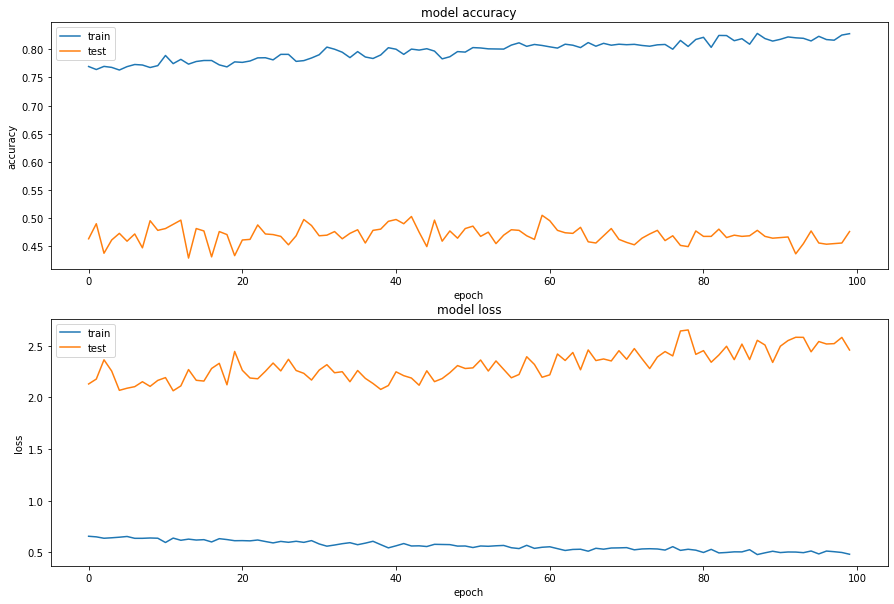

In [309]:
plt.figure(1) 
   
   
plt.subplot(211)  
plt.plot(history2c.history['accuracy'])  
plt.plot(history2c.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
   
plt.subplot(212)  
plt.plot(history2c.history['loss'])  
plt.plot(history2c.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

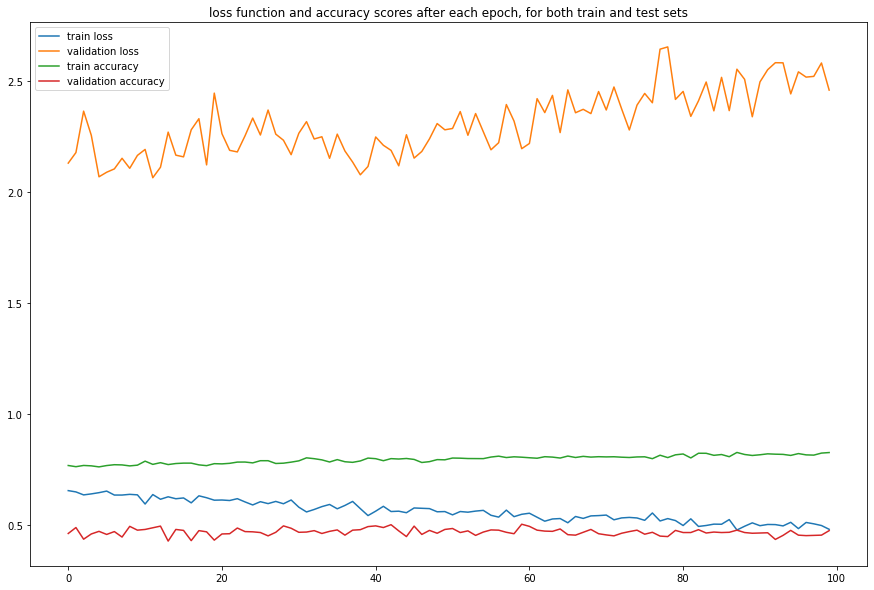

In [308]:
# Plot loss per iteration
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.title("loss function and accuracy scores after each epoch, for both train and test sets")
plt.plot(history2c.history['loss'], label='train loss')
plt.plot(history2c.history['val_loss'], label='validation loss')
plt.plot(history2c.history['accuracy'], label='train accuracy')
plt.plot(history2c.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.savefig("/Users/DELL/OneDrive/Desktop/DSE/Machine Learning/acclossc.jpg")

In [249]:
#dog
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['dog_bark'], dtype='<U16')

In [250]:
# siren
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold7/107357-8-1-10.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['siren'], dtype='<U16')

In [251]:
# children_playing
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100263-2-0-117.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model2_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['dog_bark'], dtype='<U16')

In [252]:
#dog
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100032-3-0-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['dog_bark'], dtype='<U16')

In [253]:
#car horn
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold1/24074-1-0-7.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['car_horn'], dtype='<U16')

In [254]:
#air conditionair
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold5/100852-0-0-1.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['drilling'], dtype='<U16')

In [255]:
#street music
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold7/101848-9-0-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['street_music'], dtype='<U16')

In [256]:
#gun shot
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold1/102305-6-0-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['gun_shot'], dtype='<U16')

In [257]:
#engine idling
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold2/102858-5-0-1.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['engine_idling'], dtype='<U16')

In [258]:
#jackhammer
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold1/103074-7-0-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['jackhammer'], dtype='<U16')

In [259]:
#drilling
filename = "/Users/DELL/OneDrive/Desktop/DSE/UrbanSound8K/audio/fold3/103199-4-1-0.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
predicted_label = np.argmax(model3_NN.predict(mfccs_scaled_features), axis=1)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

array(['drilling'], dtype='<U16')